In [10]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm
from scipy.signal import stft
from scipy.stats import kurtosis

In [2]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [3]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 392.78it/s]
INFO:root:Read in 58.40484142303467 seconds


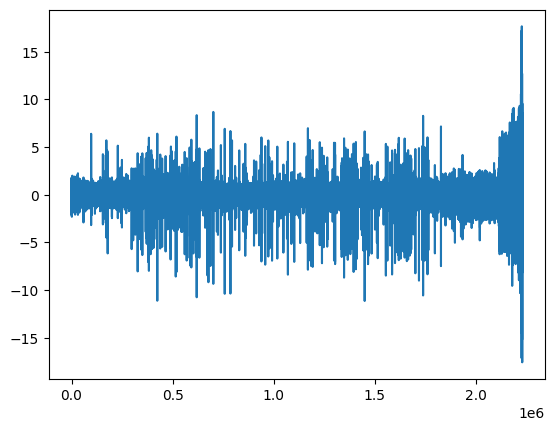

In [29]:
d_1_1 = df[0][df[0]['unit'] == '1_1']
d_1_2 = df[0][df[0]['unit'] == '1_2']
d_2_1 = df[0][df[0]['unit'] == '2_1']
d_2_2 = df[0][df[0]['unit'] == '2_2']
d_3_1 = df[0][df[0]['unit'] == '3_1']
d_3_2 = df[0][df[0]['unit'] == '3_2']

plt.plot(d_1_2['H_acc'])

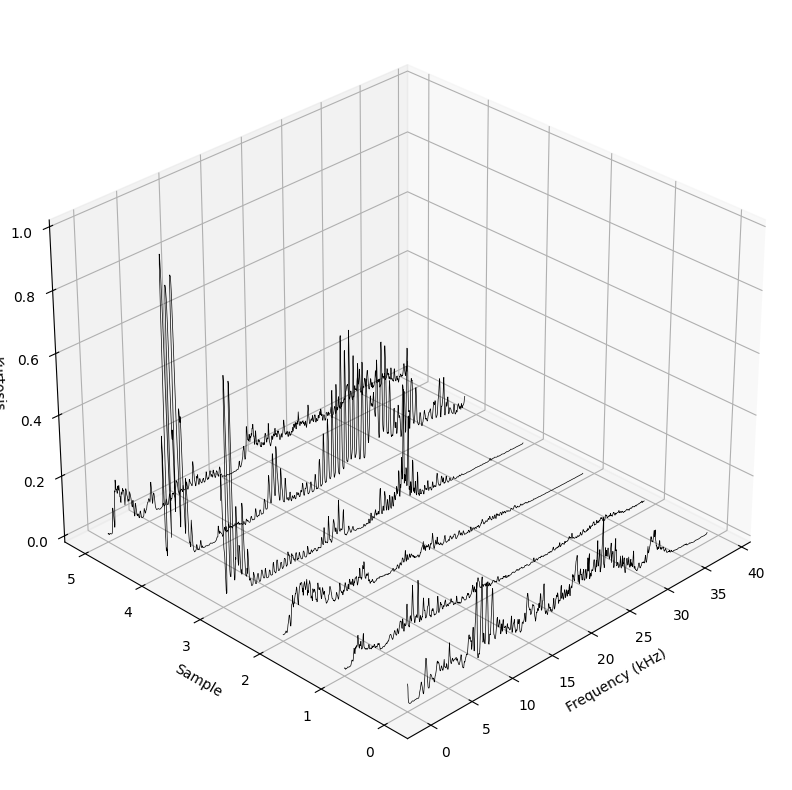

In [58]:
f = []
ffts = []

nperseg = 1024

for d in [
    d_1_1,
    d_1_2,
    d_2_1,
    d_2_2,
    d_3_1,
    d_3_2
]:
    vibration_signal = (d['H_acc'] - np.mean(d['H_acc'])) / np.std(d['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)
n = np.ones_like(f[0])

fig = plt.figure(figsize = (10.0,10.0))
ax = plt.axes(projection = '3d')
ax.view_init(30,225)
for i in range(f.shape[0]):
    ax.plot((f[i] * 3) / 1.0e3,i * n,fftn[i],color = 'black',linewidth = 0.50)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Sample')
ax.set_zlabel('Kurtosis')
plt.show()

In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


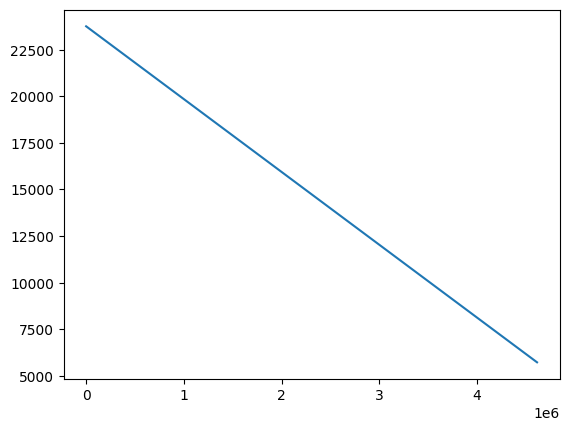

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [430]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for unit, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [371]:
len(train_dataset)

5604

In [433]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1),
            # torch.nn.Sigmoid(),
            # Removed Sigmoid() for regression
        )

        # self.fc = torch.nn.Linear(128, 1)

        # with torch.no_grad():
        #     self.fc.weight.data = -torch.abs(self.fc.weight.data)
        #     self.fc.bias.data.fill_(1.0)  # Start predictions near 1.0
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        x = self.regressor(x)  # -> (B,)
        return x

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [ ]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.7
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [435]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 50)

train_results

100%|██████████| 176/176 [00:04<00:00, 41.07it/s]


Epoch 1: Train Loss 39692.7738, Train R2 = 0.596, Train RMSE = 0.184, Train MSE = 0.034, Train MAE = 0.104


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 163.58it/s]


Epoch 1: Val Loss 39470.3743, Val R2 = -3.216, Val RMSE = 0.592, Val MSE = 0.351, Val MAE = 0.516


100%|██████████| 176/176 [00:04<00:00, 40.86it/s]


Epoch 2: Train Loss 35624.2762, Train R2 = 0.636, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.094


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 164.55it/s]


Epoch 2: Val Loss 34149.8419, Val R2 = -2.647, Val RMSE = 0.551, Val MSE = 0.303, Val MAE = 0.470


100%|██████████| 176/176 [00:04<00:00, 39.80it/s]


Epoch 3: Train Loss 43464.4262, Train R2 = 0.556, Train RMSE = 0.192, Train MSE = 0.037, Train MAE = 0.103


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 165.93it/s]


Epoch 3: Val Loss 38021.6842, Val R2 = -3.061, Val RMSE = 0.581, Val MSE = 0.338, Val MAE = 0.505


100%|██████████| 176/176 [00:04<00:00, 38.56it/s]


Epoch 4: Train Loss 44966.2529, Train R2 = 0.541, Train RMSE = 0.195, Train MSE = 0.038, Train MAE = 0.104


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 143.90it/s]


Epoch 4: Val Loss 32999.2459, Val R2 = -2.524, Val RMSE = 0.541, Val MSE = 0.293, Val MAE = 0.460


100%|██████████| 176/176 [00:05<00:00, 34.33it/s]


Epoch 5: Train Loss 48039.1503, Train R2 = 0.510, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.109


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 130.58it/s]


Epoch 5: Val Loss 31055.0691, Val R2 = -2.316, Val RMSE = 0.525, Val MSE = 0.276, Val MAE = 0.443


100%|██████████| 176/176 [00:05<00:00, 34.34it/s]


Epoch 6: Train Loss 47585.1157, Train R2 = 0.514, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.108


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 140.58it/s]


Epoch 6: Val Loss 37513.2613, Val R2 = -3.006, Val RMSE = 0.577, Val MSE = 0.333, Val MAE = 0.501


100%|██████████| 176/176 [00:05<00:00, 33.41it/s]


Epoch 7: Train Loss 51676.3223, Train R2 = 0.472, Train RMSE = 0.210, Train MSE = 0.044, Train MAE = 0.114


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 144.37it/s]


Epoch 7: Val Loss 31665.3557, Val R2 = -2.381, Val RMSE = 0.530, Val MSE = 0.281, Val MAE = 0.448


100%|██████████| 176/176 [00:05<00:00, 34.62it/s]


Epoch 8: Train Loss 53652.5858, Train R2 = 0.452, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.115


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 134.90it/s]


Epoch 8: Val Loss 40440.2136, Val R2 = -3.317, Val RMSE = 0.599, Val MSE = 0.359, Val MAE = 0.524


100%|██████████| 176/176 [00:05<00:00, 34.88it/s]


Epoch 9: Train Loss 54628.2778, Train R2 = 0.448, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.119


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 143.10it/s]


Epoch 9: Val Loss 33483.6600, Val R2 = -2.572, Val RMSE = 0.545, Val MSE = 0.297, Val MAE = 0.466


100%|██████████| 176/176 [00:05<00:00, 32.95it/s]


Epoch 10: Train Loss 62650.7012, Train R2 = 0.360, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.128


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 131.16it/s]


Epoch 10: Val Loss 35069.0027, Val R2 = -2.742, Val RMSE = 0.558, Val MSE = 0.311, Val MAE = 0.480


100%|██████████| 176/176 [00:05<00:00, 31.11it/s]


Epoch 11: Train Loss 60065.2113, Train R2 = 0.390, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.128


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 128.60it/s]


Epoch 11: Val Loss 21546.1803, Val R2 = -1.297, Val RMSE = 0.437, Val MSE = 0.191, Val MAE = 0.353


100%|██████████| 176/176 [00:05<00:00, 29.74it/s]


Epoch 12: Train Loss 61902.5778, Train R2 = 0.368, Train RMSE = 0.229, Train MSE = 0.053, Train MAE = 0.133


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 132.71it/s]


Epoch 12: Val Loss 20641.2836, Val R2 = -1.200, Val RMSE = 0.428, Val MSE = 0.183, Val MAE = 0.345


100%|██████████| 176/176 [00:05<00:00, 29.97it/s]


Epoch 13: Train Loss 63450.5215, Train R2 = 0.360, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.133


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 129.75it/s]


Epoch 13: Val Loss 26076.0190, Val R2 = -1.776, Val RMSE = 0.480, Val MSE = 0.231, Val MAE = 0.397


100%|██████████| 176/176 [00:06<00:00, 28.41it/s]


Epoch 14: Train Loss 60567.0782, Train R2 = 0.388, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.134


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 124.75it/s]


Epoch 14: Val Loss 25169.6635, Val R2 = -1.682, Val RMSE = 0.472, Val MSE = 0.223, Val MAE = 0.386


100%|██████████| 176/176 [00:06<00:00, 29.33it/s]


Epoch 15: Train Loss 63279.5049, Train R2 = 0.359, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.140


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 137.76it/s]


Epoch 15: Val Loss 30439.3911, Val R2 = -2.242, Val RMSE = 0.519, Val MSE = 0.270, Val MAE = 0.435


100%|██████████| 176/176 [00:05<00:00, 30.93it/s]


Epoch 16: Train Loss 53753.3136, Train R2 = 0.462, Train RMSE = 0.212, Train MSE = 0.045, Train MAE = 0.134


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 138.02it/s]


Epoch 16: Val Loss 23561.6519, Val R2 = -1.498, Val RMSE = 0.456, Val MSE = 0.208, Val MAE = 0.372


100%|██████████| 176/176 [00:05<00:00, 29.74it/s]


Epoch 17: Train Loss 66904.3777, Train R2 = 0.329, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.149


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 134.68it/s]


Epoch 17: Val Loss 24278.0213, Val R2 = -1.566, Val RMSE = 0.462, Val MSE = 0.213, Val MAE = 0.406


100%|██████████| 176/176 [00:06<00:00, 28.28it/s]


Epoch 18: Train Loss 64868.6875, Train R2 = 0.342, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.144


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 142.34it/s]


Epoch 18: Val Loss 28263.8028, Val R2 = -1.996, Val RMSE = 0.499, Val MSE = 0.249, Val MAE = 0.422


100%|██████████| 176/176 [00:06<00:00, 27.67it/s]


Epoch 19: Train Loss 172399.4731, Train R2 = -0.720, Train RMSE = 0.378, Train MSE = 0.143, Train MAE = 0.295


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 106.95it/s]


Epoch 19: Val Loss 10593.8125, Val R2 = -0.039, Val RMSE = 0.294, Val MSE = 0.086, Val MAE = 0.253


100%|██████████| 176/176 [00:06<00:00, 26.07it/s]


Epoch 20: Train Loss 102615.9942, Train R2 = -0.003, Train RMSE = 0.289, Train MSE = 0.084, Train MAE = 0.235


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 132.01it/s]


Epoch 20: Val Loss 12335.2278, Val R2 = -0.197, Val RMSE = 0.315, Val MSE = 0.100, Val MAE = 0.266


100%|██████████| 176/176 [00:06<00:00, 27.56it/s]


Epoch 21: Train Loss 88321.1162, Train R2 = 0.154, Train RMSE = 0.265, Train MSE = 0.070, Train MAE = 0.216


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 137.31it/s]


Epoch 21: Val Loss 15052.8438, Val R2 = -0.471, Val RMSE = 0.350, Val MSE = 0.122, Val MAE = 0.290


100%|██████████| 176/176 [00:06<00:00, 27.31it/s]


Epoch 22: Train Loss 77560.1191, Train R2 = 0.254, Train RMSE = 0.249, Train MSE = 0.062, Train MAE = 0.202


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 94.11it/s]


Epoch 22: Val Loss 15447.3321, Val R2 = -0.505, Val RMSE = 0.354, Val MSE = 0.125, Val MAE = 0.294


100%|██████████| 176/176 [00:06<00:00, 26.89it/s]


Epoch 23: Train Loss 68092.6973, Train R2 = 0.345, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.189


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 126.24it/s]


Epoch 23: Val Loss 15789.7417, Val R2 = -0.535, Val RMSE = 0.357, Val MSE = 0.128, Val MAE = 0.298


100%|██████████| 176/176 [00:06<00:00, 26.30it/s]


Epoch 24: Train Loss 60557.9470, Train R2 = 0.420, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.175


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 122.30it/s]


Epoch 24: Val Loss 14582.5536, Val R2 = -0.401, Val RMSE = 0.341, Val MSE = 0.116, Val MAE = 0.285


100%|██████████| 176/176 [00:07<00:00, 22.44it/s]


Epoch 25: Train Loss 52146.3146, Train R2 = 0.499, Train RMSE = 0.204, Train MSE = 0.042, Train MAE = 0.159


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 101.94it/s]


Epoch 25: Val Loss 13288.1947, Val R2 = -0.261, Val RMSE = 0.324, Val MSE = 0.105, Val MAE = 0.270


100%|██████████| 176/176 [00:08<00:00, 21.50it/s]


Epoch 26: Train Loss 65257.3064, Train R2 = 0.368, Train RMSE = 0.229, Train MSE = 0.053, Train MAE = 0.186


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 109.56it/s]


Epoch 26: Val Loss 11611.1403, Val R2 = -0.067, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.248


100%|██████████| 176/176 [00:07<00:00, 24.04it/s]


Epoch 27: Train Loss 52630.8790, Train R2 = 0.496, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.165


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 126.67it/s]


Epoch 27: Val Loss 12182.2595, Val R2 = -0.119, Val RMSE = 0.305, Val MSE = 0.093, Val MAE = 0.253


100%|██████████| 176/176 [00:07<00:00, 24.11it/s]


Epoch 28: Train Loss 48379.3926, Train R2 = 0.541, Train RMSE = 0.195, Train MSE = 0.038, Train MAE = 0.156


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 119.15it/s]


Epoch 28: Val Loss 12346.1052, Val R2 = -0.130, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.254


100%|██████████| 176/176 [00:08<00:00, 20.83it/s]


Epoch 29: Train Loss 45464.3495, Train R2 = 0.567, Train RMSE = 0.190, Train MSE = 0.036, Train MAE = 0.151


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 94.55it/s]


Epoch 29: Val Loss 12538.1402, Val R2 = -0.145, Val RMSE = 0.309, Val MSE = 0.095, Val MAE = 0.255


100%|██████████| 176/176 [00:09<00:00, 18.97it/s]


Epoch 30: Train Loss 44564.5011, Train R2 = 0.585, Train RMSE = 0.186, Train MSE = 0.035, Train MAE = 0.148


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 93.31it/s]


Epoch 30: Val Loss 12526.9014, Val R2 = -0.141, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.255


100%|██████████| 176/176 [00:09<00:00, 19.17it/s]


Epoch 31: Train Loss 43166.8251, Train R2 = 0.597, Train RMSE = 0.183, Train MSE = 0.034, Train MAE = 0.145


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 95.18it/s]


Epoch 31: Val Loss 12597.8576, Val R2 = -0.146, Val RMSE = 0.309, Val MSE = 0.095, Val MAE = 0.255


100%|██████████| 176/176 [00:09<00:00, 19.51it/s]


Epoch 32: Train Loss 41701.0060, Train R2 = 0.609, Train RMSE = 0.180, Train MSE = 0.033, Train MAE = 0.143


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 101.86it/s]


Epoch 32: Val Loss 12545.7939, Val R2 = -0.140, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:09<00:00, 19.27it/s]


Epoch 33: Train Loss 40873.4335, Train R2 = 0.621, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.141


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 95.54it/s]


Epoch 33: Val Loss 12533.1550, Val R2 = -0.138, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:08<00:00, 19.63it/s]


Epoch 34: Train Loss 40403.6233, Train R2 = 0.621, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.140


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 101.63it/s]


Epoch 34: Val Loss 12534.6127, Val R2 = -0.138, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:09<00:00, 19.06it/s]


Epoch 35: Train Loss 41517.9064, Train R2 = 0.614, Train RMSE = 0.179, Train MSE = 0.032, Train MAE = 0.142


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 90.92it/s]


Epoch 35: Val Loss 12520.1835, Val R2 = -0.136, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.254


100%|██████████| 176/176 [00:09<00:00, 18.76it/s]


Epoch 36: Train Loss 41066.6251, Train R2 = 0.622, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 95.66it/s]


Epoch 36: Val Loss 12549.7994, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:11<00:00, 15.10it/s]


Epoch 37: Train Loss 40763.9276, Train R2 = 0.620, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.141


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 97.10it/s]


Epoch 37: Val Loss 12564.6144, Val R2 = -0.140, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:09<00:00, 18.19it/s]


Epoch 38: Train Loss 40447.9717, Train R2 = 0.627, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.139


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 98.11it/s]


Epoch 38: Val Loss 12558.9544, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:08<00:00, 19.78it/s]


Epoch 39: Train Loss 41185.1052, Train R2 = 0.618, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.141


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 95.58it/s]


Epoch 39: Val Loss 12557.5504, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:11<00:00, 15.77it/s]


Epoch 40: Train Loss 39298.4919, Train R2 = 0.628, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.139


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 87.59it/s]


Epoch 40: Val Loss 12557.5364, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 16.38it/s]


Epoch 41: Train Loss 39569.7240, Train R2 = 0.627, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.140


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 96.34it/s]


Epoch 41: Val Loss 12557.4625, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 17.24it/s]


Epoch 42: Train Loss 40251.3780, Train R2 = 0.623, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 89.94it/s]


Epoch 42: Val Loss 12557.1204, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 17.49it/s]


Epoch 43: Train Loss 40357.2855, Train R2 = 0.625, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 95.61it/s]


Epoch 43: Val Loss 12557.0952, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 17.40it/s]


Epoch 44: Train Loss 40853.6665, Train R2 = 0.617, Train RMSE = 0.179, Train MSE = 0.032, Train MAE = 0.141


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 97.21it/s]


Epoch 44: Val Loss 12555.9619, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 16.15it/s]


Epoch 45: Train Loss 40968.2501, Train R2 = 0.618, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.141


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 62.99it/s]


Epoch 45: Val Loss 12555.6792, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:09<00:00, 17.94it/s]


Epoch 46: Train Loss 40266.4348, Train R2 = 0.622, Train RMSE = 0.177, Train MSE = 0.032, Train MAE = 0.140


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 81.96it/s]


Epoch 46: Val Loss 12555.8694, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 16.28it/s]


Epoch 47: Train Loss 40505.7181, Train R2 = 0.621, Train RMSE = 0.178, Train MSE = 0.032, Train MAE = 0.140


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 95.16it/s]


Epoch 47: Val Loss 12555.7999, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:11<00:00, 14.72it/s]


Epoch 48: Train Loss 40572.6832, Train R2 = 0.623, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 80.89it/s]


Epoch 48: Val Loss 12555.9604, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:11<00:00, 15.96it/s]


Epoch 49: Train Loss 40423.0961, Train R2 = 0.626, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 87.12it/s]


Epoch 49: Val Loss 12555.8568, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


100%|██████████| 176/176 [00:10<00:00, 16.40it/s]


Epoch 50: Train Loss 40521.5922, Train R2 = 0.623, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.140


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 80.82it/s]

Epoch 50: Val Loss 12556.0824, Val R2 = -0.139, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.254


{'train_loss': [39692.773832841354,
  35624.27623610063,
  43464.42623277144,
  44966.25293176824,
  48039.150315024635,
  47585.115698380905,
  51676.322321805084,
  53652.585829301315,
  54628.277775157585,
  62650.70123707165,
  60065.21126764471,
  61902.57778514515,
  63450.52149408514,
  60567.07816245339,
  63279.504938299004,
  53753.31364302202,
  66904.37765641646,
  64868.68751040372,
  172399.47307101163,
  102615.99419056285,
  88321.11617625844,
  77560.11910317162,
  68092.69730030406,
  60557.94702842019,
  52146.314633456146,
  65257.306400645866,
  52630.87902346524,
  48379.392571189186,
  45464.3494942405,
  44564.50106117942,
  43166.825087807396,
  41701.006039706146,
  40873.43354797363,
  40403.6233326305,
  41517.90643587979,
  41066.62505271218,
  40763.92763380571,
  40447.97174765847,
  41185.105188543144,
  39298.49188579212,
  39569.72397405451,
  40251.377969915215,
  40357.285521073776,
  40853.66648171165,
  40968.250140797005,
  40266.43480890447,
  40

In [436]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



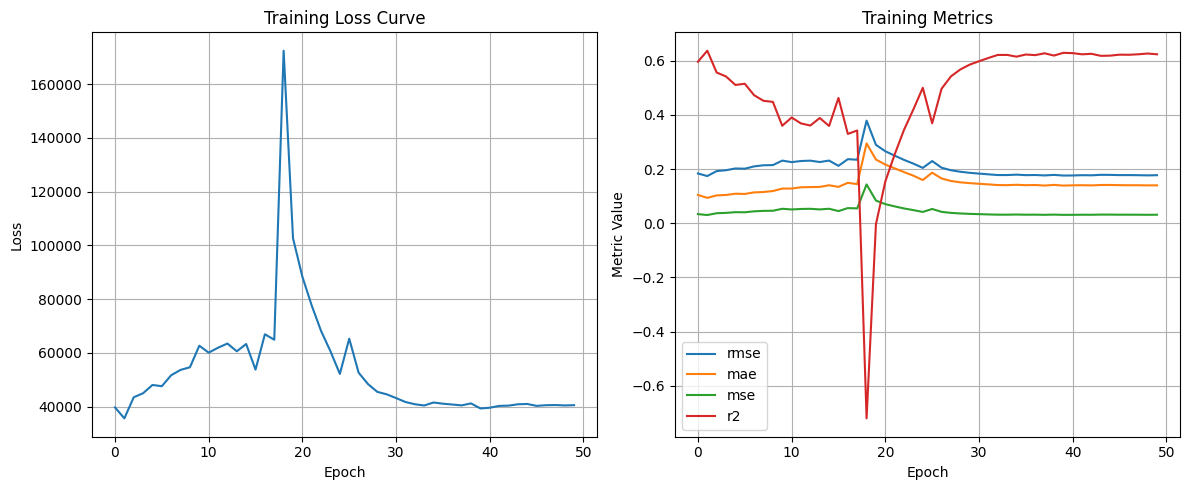

In [444]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [377]:
len(test_loader)

113

In [441]:
model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [442]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 142.91it/s]


{'test_r2': [-0.9601264807783019],
 'test_mae': [0.24826926],
 'test_mse': [0.09393763],
 'test_rmse': [0.30649245],
 'test_preds': array([0.42257375, 0.38137135, 0.37827882, ..., 0.30334586, 0.22625235,
        0.26379114], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

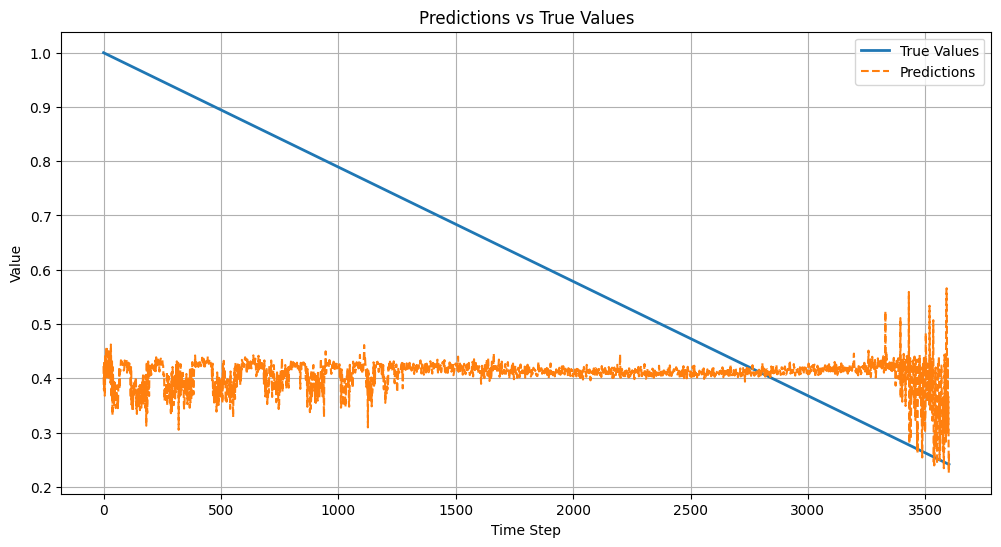

In [443]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

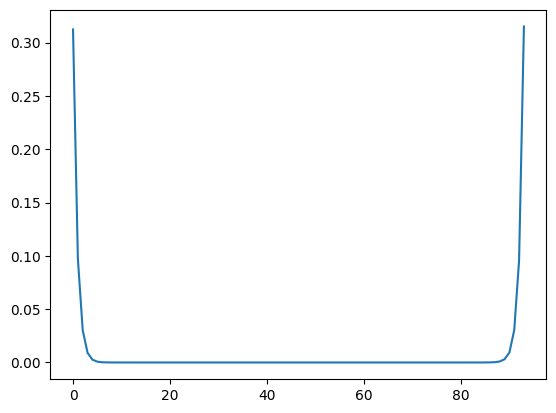

In [151]:
plt.plot(test_results['rul'].cpu().numpy())